In [1]:
import msiwarp as mx

from msiwarp.util.read_sbd import read_sbd_meta, read_spectrum_fs
from msiwarp.util.warp import to_mx_peaks, to_mz, to_height, peak_density_mz
from msiwarp.util.warp import spectra_to_triplet, plot_range, get_mx_spectrum
from msiwarp.util.warp import generate_mean_spectrum

import matplotlib.pyplot as plt
import numpy as np


# scaling to test impact of sigma on alignment performance
sigma_1 = 1.5e-4
epsilon = 2.55
slack = 2.0 * epsilon * sigma_1

print("sigma: {} ppm, and epsilon: {:0.2f} ppm".format(sigma_1 * 1e6, slack * 1e6))

fdir = 'datasets/tof-kidney/'

fpath_sbd = fdir + '50um_sample_3neg-centroided-snr.sbd'
fpath_triplets_raw = fdir + 'triplets_raw.dat'
fpath_triplets_warped = fdir + 'triplets_warped.dat'
fpath_dispersion_csv = fdir + 'results/dispersion_100.csv'
fpath_scatter = fdir + 'results/scatter'

# experiment settings
instrument_type = 'tof'
mz_begin = 450
mz_end = 2000

meta = read_sbd_meta(fpath_sbd)
spectra = [get_mx_spectrum(fpath_sbd, meta, i, sigma_1, instrument_type) for i in range(len(meta))]
tic = np.array([m[2] for m in meta])

sigma: 150.0 ppm, and epsilon: 765.00 ppm


In [3]:
n_steps = 50
n_peaks = 30
max_n_nodes = 8

ransac_params = mx.ransac_params(2,       # n_segments
                                 50,      # n_iterations
                                 2,       # n_samples
                                 10,      # min_n_pairs
                                 25,      # n_steps
                                 slack,
                                 mz_begin,
                                 mz_end,
                                 1.0)

node_params = mx.params_uniform(mx.Instrument.TOF,
                                n_steps,
                                n_peaks,
                                max_n_nodes,
                                mz_begin,
                                mz_end,
                                slack)



# --------- set reference spectrum ----------
i_r = 200
s_ref = spectra[i_r]

In [4]:
import time

n_cores = 5

t0 = time.time()
warping_funcs = mx.find_optimal_warpings_ransac_uni(spectra, s_ref, ransac_params, node_params, epsilon, n_cores)
t1 = time.time()
print("found optimal warpings in {:0.2f} seconds".format(t1 - t0))

t2 = time.time()
warped_spectra = [mx.warp_peaks_unique(s_i, r_i) for (s_i, r_i) in zip(spectra, warping_funcs)]
t3 = time.time()
print("warped spectra in {:0.2f}s".format(t3 - t2))

found optimal warpings in 378.74 seconds
warped spectra in 9.75s


In [68]:
# save raw and warped data spectra in the MSI triplet format
if mx.spectra_to_triplets(fpath_triplets_raw, spectra):
    print("wrote raw MSI triplets to file")
    
if mx.spectra_to_triplets(fpath_triplets_warped, warped_spectra):
    print("wrote warped MSI triplets to file")

wrote raw MSI triplets to file
wrote warped MSI triplets to file


generating mean spectrum with 39779 sampling points...
generated mean spectrum
made scatter plot output directory


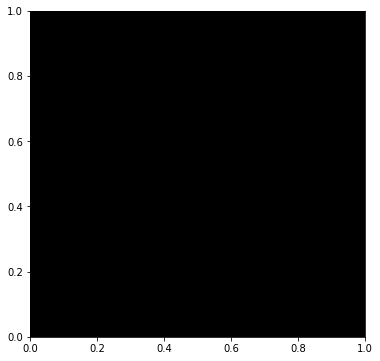

In [69]:
# ---------- mean spectrum ----------
n_points = 500000

s_m = generate_mean_spectrum(warped_spectra, n_points, sigma_1,
                             mz_begin, mz_end, tic, instrument_type)

s_m_100 = mx.peaks_top_n(s_m, 100)
mz_ref = np.sort(to_mz(s_m_100))


# ---------- plot mass scatter around mean spectrum peaks ----------
mass_tolerance = 350 # ppm

import os

if not os.path.exists(fpath_scatter):    
    os.makedirs(fpath_scatter)
    print("made scatter plot output directory")
else:
    print("using existing scatter plot output directory")
    
fig, ax = plt.subplots(figsize=(6,6))
for i, mz_i in enumerate(mz_ref):
    d = mass_tolerance * mz_i / 1e6 # -+ 350 ppm around reference mass 
    mz0 = mz_i - d
    mz1 = mz_i + d    
    
    plot_range(fpath_triplets_raw, mz0, mz1, ax, 'tab:cyan', 5)
    plot_range(fpath_triplets_warped, mz0, mz1, ax, 'tab:orange', 5)
    
    ax.set_facecolor((0.0, 0.0, 0.0))
    ax.set_title('m/z {:0.3f}'.format(mz_i))
    ax.set_xticks([mz0, mz_i, mz1])
    
    fig.savefig(fpath_scatter + '/mz_{}.png'.format(int(mz_i)), dpi=200)
    ax.cla()

In [70]:
# ---------- compute mass dispersions around mean spectrum ----------
from msiwarp.util.warp import dispersion_triplets
import pandas as pd

dispersion_raw = np.zeros(len(mz_ref))
dispersion_warped = np.zeros(len(mz_ref))
    
for i, mz_i in enumerate(mz_ref):
    d = mass_tolerance * mz_i / 1e6 # -+ 350 ppm around reference mass
    mz0 = mz_i - d
    mz1 = mz_i + d
    
    ts_raw = mx.get_triplets_range(fpath_triplets_raw, mz0, mz1)
    ts_warped = mx.get_triplets_range(fpath_triplets_warped, mz0, mz1)
    
    q = 0.25 # remove background signal
    if len(ts_raw) > 0:
        dispersion_raw[i] = dispersion_triplets(ts_raw,  q)
    if len(ts_warped) > 0:  
        dispersion_warped[i] = dispersion_triplets(ts_warped, q)


d = {'mz': mz_ref,
     'dispersion raw [ppm]': dispersion_raw,
     'dispersion warped [ppm]': dispersion_warped}

df = pd.DataFrame(d)
df.round(4).to_csv(fpath_dispersion_csv, index=False)

print('median mass dispersion raw: {:0.4f}'.format(np.median(dispersion_raw)))
print('median mass dispersion warped: {:0.4f}'.format(np.median(dispersion_warped)))

median mass dispersion raw: 107.0129
median mass dispersion warped: 12.8076


281


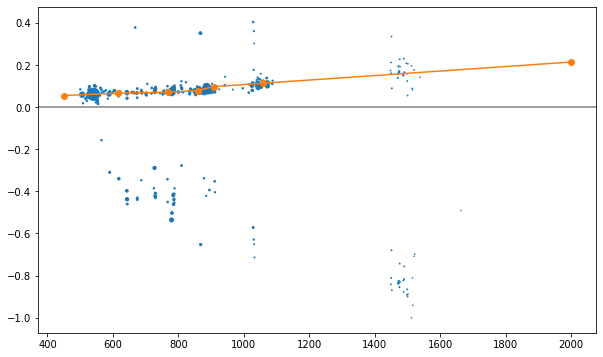

In [67]:
from msiwarp.util.warp import plot_peak_matches, plot_warping

i_s = np.random.choice(len(spectra))
s_s = spectra[i_s]

recal = warping_funcs[i_s]
xw = ([w[0] for w in recal])
yw = np.array([w[1] for w in recal])

pms = mx.overlapping_peak_pairs(s_ref, s_s, epsilon)
n_peak_matches = len(pms)
print(n_peak_matches)
    
_, ax = plt.subplots(figsize=(10,6))
ax.axhline(0, c='tab:gray')
plot_peak_matches(pms, 0.5, 150, ax=ax)
ax.plot(xw, -yw, '-o', c='tab:orange')
plt.show()

ransac took 16.47 milliseconds
1


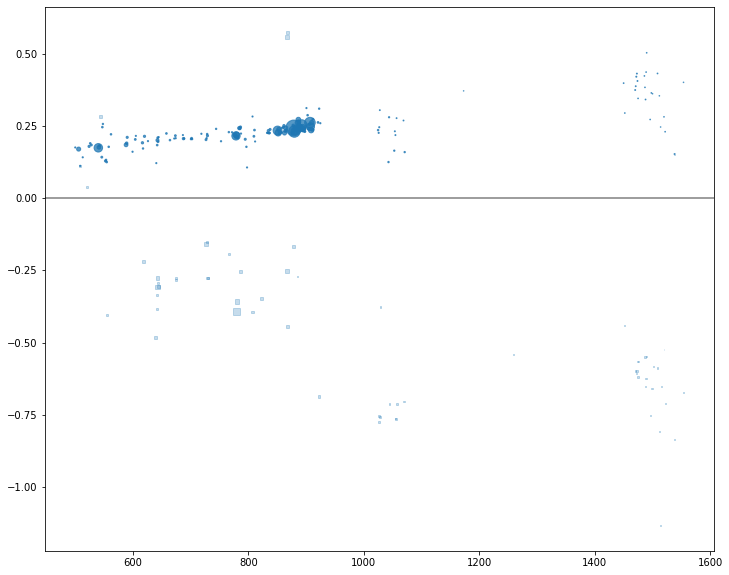

In [126]:
from msiwarp.util.warp import plot_peak_matches

# Test RANSAC
i_r = 200
i_s = np.random.choice(len(spectra))
s_s = spectra[i_s]
s_r = spectra[i_r]

pms = mx.overlapping_peak_pairs(s_r, s_s, epsilon)

ransac_nodes = mx.get_warping_nodes_uniform(pms, node_params)
pms_range = [mx.peak_pairs_between(pms, ransac_nodes[i].mz, ransac_nodes[i+1].mz) for i in range(len(ransac_nodes) - 1)]
rr = mx.ransac(pms_range, ransac_nodes, ransac_params.n_iterations, ransac_params.n_samples, ransac_params.distance_threshold)
i_best_model = np.argmax([np.sum(inliers) for inliers in rr.inliers])
inliers = rr.inliers[i_best_model]

pms_inliers = [pms[i] for i in range(len(pms)) if inliers[i]]
pms_outliers = [pms[i] for i in range(len(pms)) if not inliers[i]]

t0 = time.time()
pms_ransac = mx.ransac_pairs(pms, ransac_params, node_params)
t1 = time.time()

print("ransac took {:0.2f} milliseconds".format((t1 - t0) * 1e3))
print(len(pms_ransac) - len(pms_inliers))

_, ax = plt.subplots(figsize=(12,10))
ax.axhline(0, c='tab:gray')
plot_peak_matches(pms_ransac, 0.5, 250, ax=ax, c='tab:blue', alpha=0.75)
plot_peak_matches(pms_outliers, 0.5, 50, ax=ax, c='tab:blue', alpha=0.25, marker='s')

# ax.plot(xw, -yw, '-o', c='tab:orange')
plt.show()